# Lista Prática - Questão 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from examples.seismic import Model, plot_velocity, TimeAxis, setup_geometry, RickerSource, AcquisitionGeometry
from devito import *
import gc
%matplotlib inline

## Parâmetros dos operadores de diferenças finitas

In [2]:
space_order=2

## Definição do modelo

### Dimensões do modelo

In [3]:
shape = (151, 151)
spacing = (10., 10.)
origin = (0., 0.)
nbl=325
# nbl=100

### Parâmetros físicos

In [4]:
v = 2.0 * np.ones(shape, dtype=np.float32) # Velocidade da onda P em km/s
v[:, shape[1]//2:] = 3.0

rho = 2.0 * np.ones(shape, dtype=np.float32) # Densidade em g/cm^3
rho[:, shape[1]//2:] = 3.0

In [5]:
model = Model(vp=v, b=1/rho, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbl=nbl, bcs="damp")

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


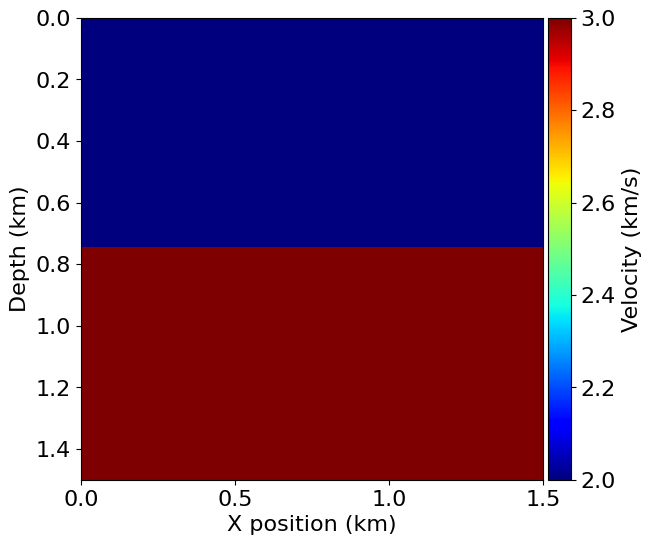

In [6]:
plot_velocity(model)

## Parâmetros da aquisição

### Tempo de aquisição

In [7]:
t0 = 100.  # ms
tn = 2000. # ms
# dt = model.critical_dt
dt = 2

time_range = TimeAxis(start=t0, stop=tn, step=dt)

### Geometria

In [8]:
# Frequência de pico da fonte
f0 = 0.010

In [9]:
# geometry = setup_geometry(model, tn, f0=f0)
geometry = AcquisitionGeometry(model, np.array([[0,0]], dtype=model.dtype), np.array([[0,0]], dtype=model.dtype), t0, tn)
geometry.resample(dt)

In [10]:
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, 1] = 0

#### Gráfico da fonte

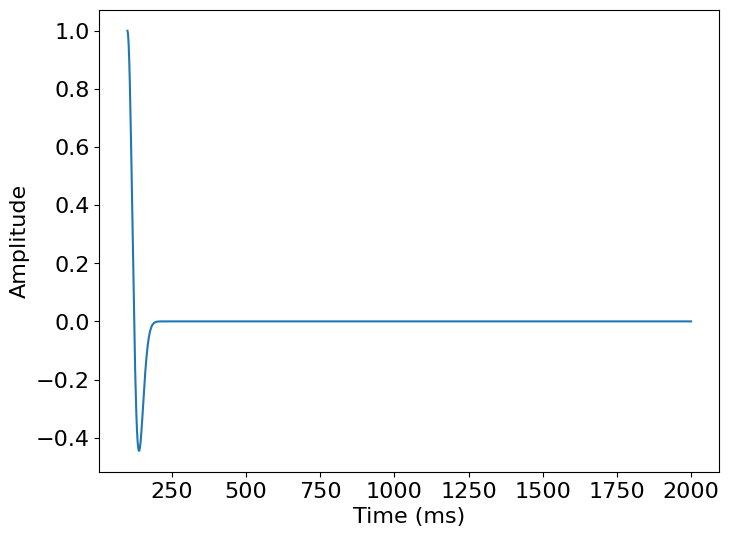

In [11]:
src.show()

#### Posição da fonte

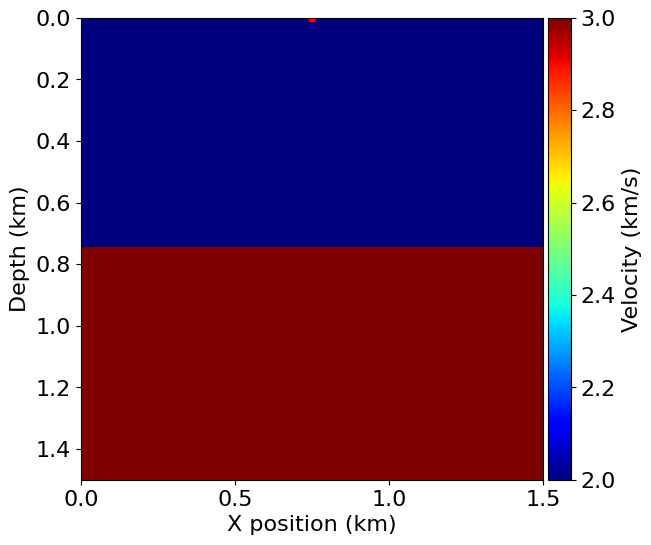

In [12]:
plot_velocity(model, source=src.coordinates.data)

## Resolução da alternativa e)

### Definição da equação da onda acústica de 2ª ordem

In [13]:
# Função pra o campo de pressão
P = TimeFunction(name="P", grid=model.grid, time_order=2, space_order=space_order, save=geometry.nt, staggered=NODE)

In [14]:
vp = model.vp
rho = 1/model.b

In [15]:
# Equação da onda acústica de 2ª ordem
EDP = 1/vp**2 * P.dt2 - rho * div( 1/rho * grad(P, .5), -.5)
EDP

-(Derivative(b(x, y)*Derivative(P(time, x, y), x), x) + Derivative(b(x, y)*Derivative(P(time, x, y), y), y))/b(x, y) + Derivative(P(time, x, y), (time, 2))/vp(x, y)**2

In [16]:
# Expressão para o campo de ondas futuro, P(r, t + dt)
stencil = Eq(P.forward, solve(EDP, P.forward))
stencil

Eq(P(time + dt, x, y), dt**2*((Derivative(b(x, y)*Derivative(P(time, x, y), x), x) + Derivative(b(x, y)*Derivative(P(time, x, y), y), y))/b(x, y) - (-2.0*P(time, x, y)/dt**2 + P(time - dt, x, y)/dt**2)/vp(x, y)**2)*vp(x, y)**2)

In [17]:
# Símbolo do espaçamento temporal
s = model.grid.stepping_dim.spacing

# Expressão do termo fonte a ser injetada no stencil criado acima
src_term = src.inject(field=P.forward, expr=src * s**2 * vp**2)

### Criação do operador de diferenças finitas

In [18]:
# Criação do operador do Devito
op = Operator([stencil] + src_term, subs=model.spacing_map)

In [19]:
# Execução
op(dt=dt)

Operator `Kernel` ran in 1.13 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.1238090000000007, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00048200000000000456, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [20]:
# NBVAL_IGNORE_OUTPUT

def plot(a, title=None):
    # Some useful definitions for plotting if nbl is set to any other value than zero
    shape_pad = np.array(shape) + 2 * nbl
    origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
    extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])
    # Note: flip sense of second dimension to make the plot positive downwards
    plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
                origin_pad[1] + extent_pad[1], origin_pad[1]]
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 5
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=15)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(src.coordinates.data[0, 0], src.coordinates.data[0, 1], 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*(count + 1)*dt + t0), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)

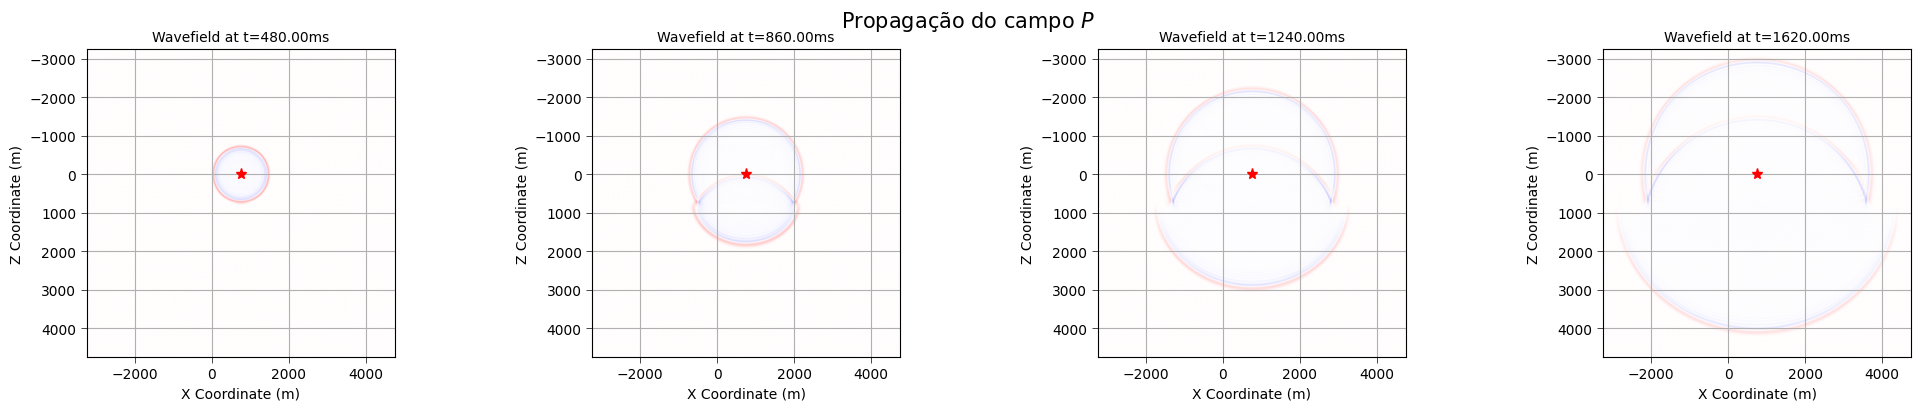

In [21]:
plot(P, title="Propagação do campo $P$")

### Definição da equação da onda acústica de 1ª ordem

In [22]:
P = TimeFunction(name="P", grid=model.grid, time_order=1, space_order=space_order, save=geometry.nt, staggered=NODE)
gc.collect()
# Função para o campo de velocidade de partícula.
V = VectorTimeFunction(name="V", grid=model.grid, time_order=1, space_order=space_order, save=geometry.nt)

In [23]:
EDP_V = V.dt + grad(P)/rho
EDP_P = P.dt + rho*vp**2 * div(V.forward)

In [24]:
stencil_P = Eq(P.forward, solve(EDP_P, P.forward))
stencil_V = Eq(V.forward, solve(EDP_V, V.forward))

In [25]:
src_term = src.inject(field=P.forward, expr=src * dt)

### Criação do operador de diferenças finitas

In [26]:
op = Operator([stencil_V, stencil_P] + src_term, subs=model.spacing_map)

In [27]:
op(dt=dt)

Operator `Kernel` ran in 2.44 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=2.438866999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0004420000000000037, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

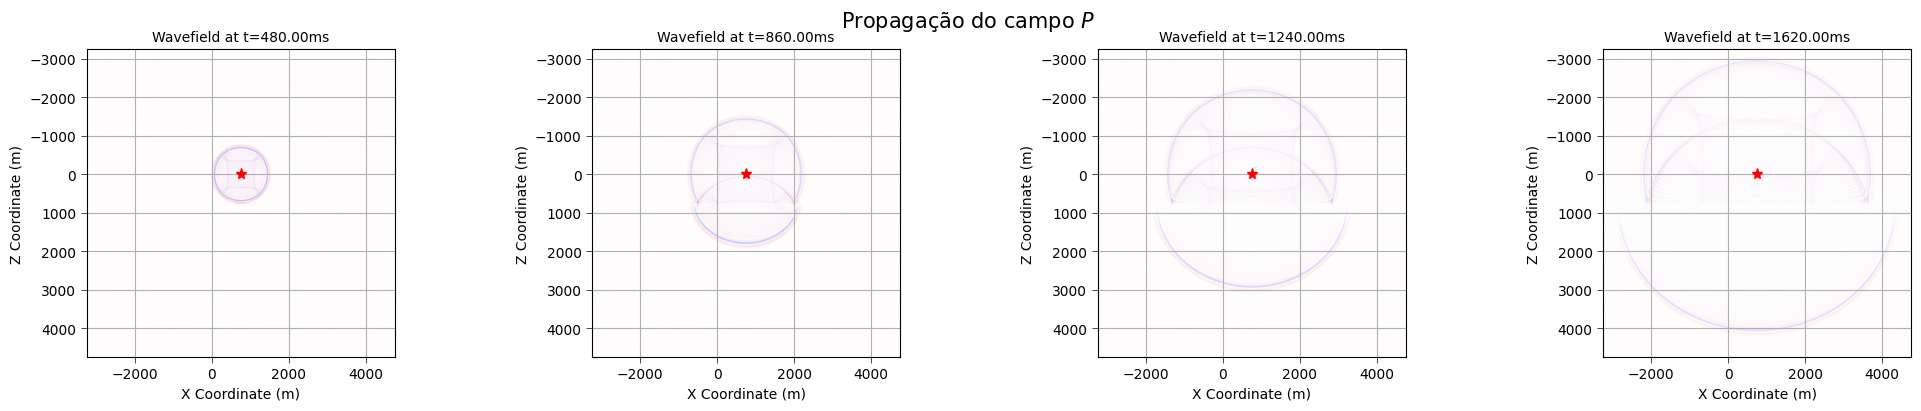

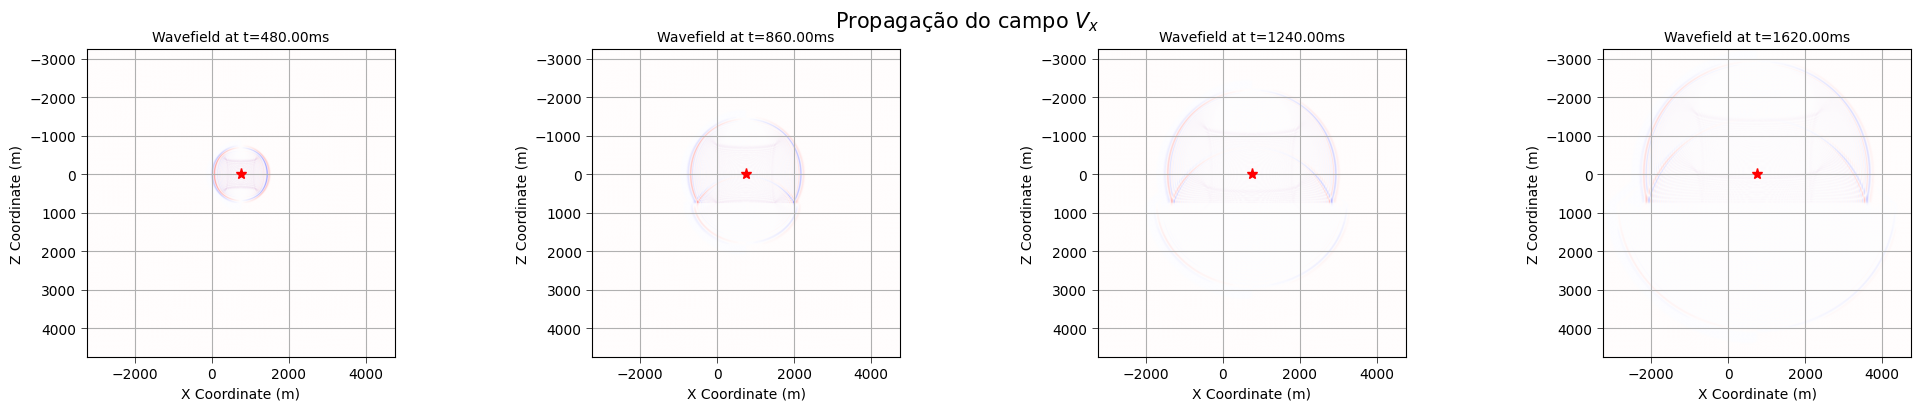

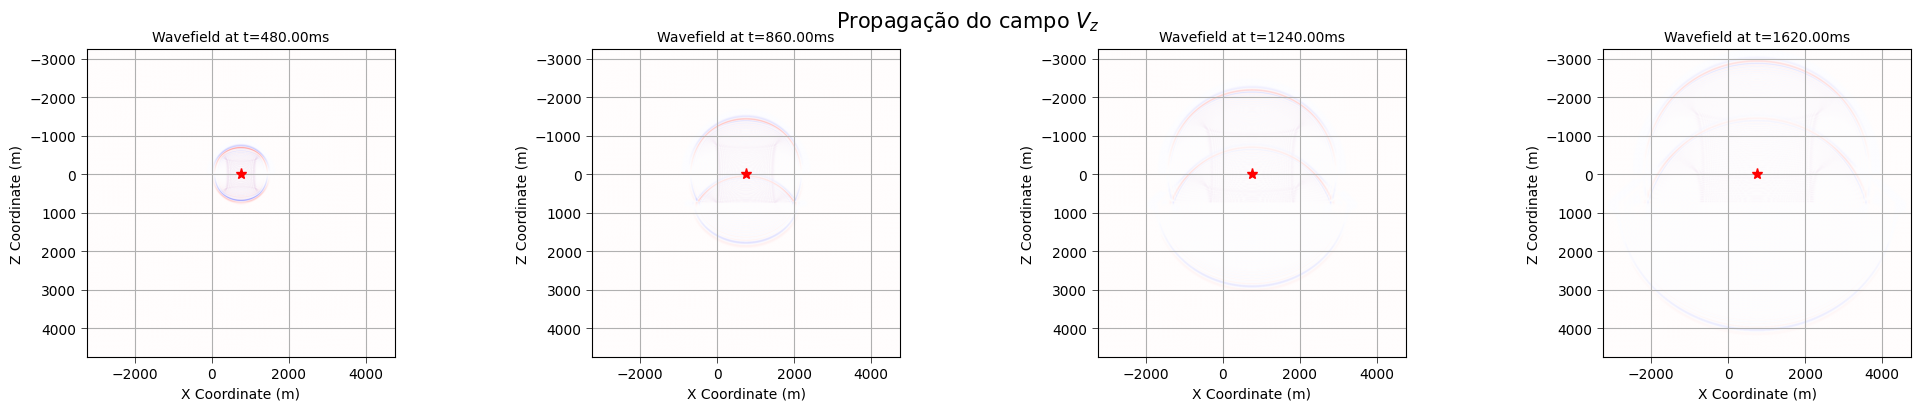

: 

In [ ]:
plot(P, title="Propagação do campo $P$")
plot(V[0], title="Propagação do campo $V_x$")
plot(V[1], title="Propagação do campo $V_z$")